<a href="https://colab.research.google.com/github/DilumFernando/diffusion-demo-dilum/blob/main/ddpm_swissroll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising diffusion: 2D Swiss roll

Generative modeling with DDPMs is demonstrated on the basis of a toy example. A 2D version of the good old Swiss roll data set is used to train a simple denoising diffusion model. The example merely serves the purpose of quickly familiarizing with the algorithm and its properties. Most of the model architecture or hyperparameter choices are quite arbitrary.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

## Using the repo directly

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Diffusion_Models

/content/drive/MyDrive/Diffusion_Models


In [ ]:
main_path = '/content/drive/MyDrive/Diffusion_Models/diffusion-demo-dilum'
sys.path.append(main_path)

## Rest of the code

In [ ]:
!pip install pytorch-lightning

In [ ]:
!pip3 install prdc

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_moons, make_s_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from prdc import compute_prdc

## Swiss roll data

Synthetic training and validation sets are generated in the following, totalling $N=2000$ samples $\{\boldsymbol{x}_{0,i}\}_{i=1}^N$. They are created with function `make_swiss_roll` from scikit-learn. The data are restricted to two dimensions and scaled. Any further normalization will be omitted.

In [ ]:
def create_swiss_roll_samples(num_samples=5000, noise_level=0.5, random_state=None):
  random_state = 42
  X, _ = make_swiss_roll(num_samples, noise=noise_level, random_state=random_state)

  # Restrict to 2D
  X = X[:,[0,2]]

  # Normalize to be between -1 and 1
  scaler = MinMaxScaler(feature_range=(-1, 1))
  X_normalized = scaler.fit_transform(X)

  return X_normalized

In [ ]:
def create_moons_samples(num_samples=5000, noise_level=0.1):
  random_state = 42 # for the make_moons

  X, y = make_moons(num_samples, noise=noise_level, random_state=random_state)

  # Normalize to be between -1 and 1
  scaler = MinMaxScaler(feature_range=(-1, 1))
  X_normalized = scaler.fit_transform(X)

  return X_normalized, y

In [ ]:
def create_s_curve(num_samples=5000, noise_level=0.1, random_state=42):
  random_state = random_state

  # Generate S-curve data in 3D
  X, y = make_s_curve(num_samples, noise=noise_level, random_state=random_state)

  # Project to 2D by taking the first two dimensions
  X = X[:,[0,2]]

  scaler = MinMaxScaler(feature_range=(-1, 1))
  X_normalized = scaler.fit_transform(X)

  return X_normalized

In [ ]:
def create_8_gaussians(num_samples=5000, random_state=42):
  # Set random seed for reproducibility
  np.random.seed(random_state)

  # Number of data points per Gaussian
  n_points = int(num_samples / 8)

  radius = 8

  # Parameters for the Gaussian distributions
  means = [(radius/np.sqrt(2), radius/np.sqrt(2)), (radius/np.sqrt(2), -radius/np.sqrt(2)), (-radius/np.sqrt(2), radius/np.sqrt(2)), (-radius/np.sqrt(2), -radius/np.sqrt(2)),
           (0, -radius), (0, radius), (radius, 0), (-radius, 0)]
  covariance = np.eye(2)  # Identity matrix as covariance for all Gaussians

  # Generate data points for each Gaussian
  X = np.zeros((len(means) * n_points, 2))
  for i, mean in enumerate(means):
      X[i * n_points:(i + 1) * n_points] = np.random.multivariate_normal(mean, covariance, n_points)

  scaler = MinMaxScaler(feature_range=(-1, 1))
  X_ = X
  X_normalized = scaler.fit_transform(X)

  return X_normalized, X_


In [ ]:
input = 'moons'

In [ ]:
if input == 'swiss_roll':
  X_normalized = create_swiss_roll_samples()
elif input == 'moons':
  X_normalized, labels = create_moons_samples()
elif input == 's_curve':
  X_normalized = create_s_curve()
else:
  X_normalized, X_ = create_8_gaussians()

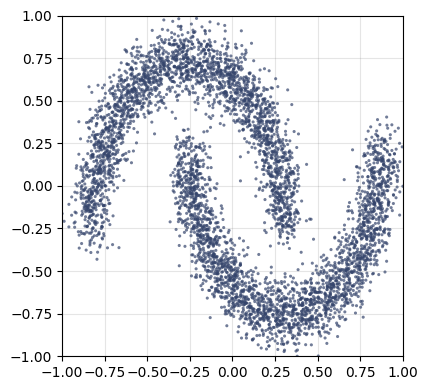

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(X_normalized[:,0], X_normalized[:,1], s=5,
    edgecolors='none', alpha=0.7, color=plt.cm.cividis(0.2))
ax.set(xlim=(-1, 1), ylim=(-1, 1))
ax.set_aspect('equal', adjustable='box')
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

## Data visualization and creating the training and validation sets

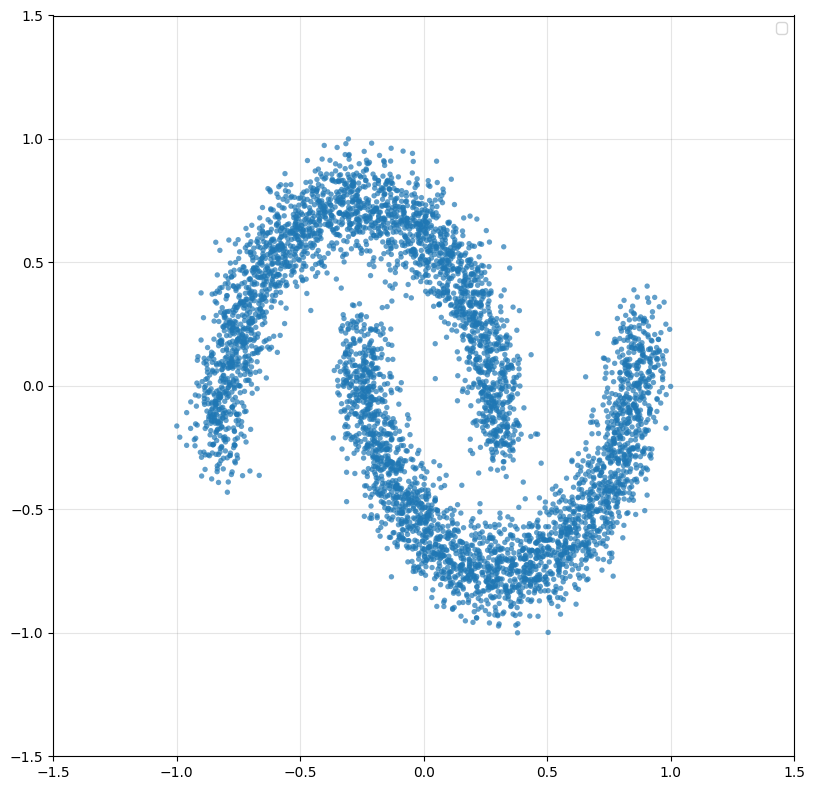

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X_normalized[:,0], X_normalized[:,1], s=15, alpha=0.7, edgecolors='none')
# ax.scatter(X_normalized[labels == 0][:, 0], X_normalized[labels == 0][:, 1], s=15, alpha=0.7, edgecolors='none', color='orange', label='Class 0')
# ax.scatter(X_normalized[labels == 1][:, 0], X_normalized[labels == 1][:, 1], s=15, alpha=0.7, edgecolors='none', color='blue', label='Class 1')
ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
ax.set_aspect('equal', adjustable='box')
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
ax.legend()
fig.tight_layout()

After the data have been generated, PyTorch `TensorDataset`s and `DataLoader`s are constructed. They allow for assembling and accessing mini-batches of data during training.

In [ ]:
# X_train, X_val = train_test_split(X, test_size=0.2)
# Enter the normalized dataset
X_train, X_val = train_test_split(X_normalized, test_size=0.2)

X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()

train_set = TensorDataset(X_train)
val_set = TensorDataset(X_val)

print('No. train images:', len(train_set))
print('No. val. images:', len(val_set))

No. train images: 4000
No. val. images: 1000


In [ ]:
batch_size = 64

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    drop_last=False,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print('No. train batches:', len(train_loader))
print('No. val. batches:', len(val_loader))

No. train batches: 62
No. val. batches: 16


## DDPM


An instance of `ConditionalDenseModel` is employed as the model $\boldsymbol{\epsilon}_\boldsymbol{\theta}(\boldsymbol{x}_t, t)$. It is composed of a number of fully connected layers and ReLU activation functions. Every layer is explicitly conditioned on the time $t$.

In [ ]:
%cd /content/drive/MyDrive/Diffusion_Models/diffusion-demo-dilum
! git pull

/content/drive/MyDrive/Diffusion_Models/diffusion-demo-dilum
Already up to date.


## Create the model

In [ ]:
from diffusion import *

def create_model(model_name, reg=None, kurt_reg=None):

  from diffusion import (
    ConditionalDenseModel,
    make_beta_schedule
  )

  num_features = [2, 128, 128, 128, 2]

  eps_model = ConditionalDenseModel(
      num_features,
      activation='relu',
      embed_dim=50
  )

  betas = make_beta_schedule(num_steps=1000, mode='linear', beta_range=(1e-04, 0.02))
  # betas = make_beta_schedule(num_steps=1000, mode='quadratic', beta_range=(1e-04, 0.02))
  # betas = make_beta_schedule(num_steps=time_steps, mode='cosine', cosine_s=0.008)
  # betas = make_beta_schedule(num_steps=1000, mode='sigmoid', sigmoid_range=(-5, 5))

  if 'original' in model_name:
    from diffusion.ddpm import DDPM as ddpm
    print('original')
    ddpm = ddpm(
      eps_model=eps_model,
      betas=betas,
      criterion='mse',
      lr=1e-03)
    print(f'reg :{reg}')
    print(f'kurt_reg : {kurt_reg}')

  elif 'norms' in model_name:
    from diffusion.ddpm_norms import DDPM as ddpm
    print('norms')
    ddpm = ddpm(
      eps_model=eps_model,
      betas=betas,
      criterion='mse',
      lr=1e-03,
      reg=reg)
    print(f'reg :{reg}')
    print(f'kurt_reg : {kurt_reg}')

  else:
    from diffusion.ddpm_kurtosis import DDPM as ddpm
    print('kurtosis')
    ddpm = ddpm(
      eps_model=eps_model,
      betas=betas,
      criterion='mse',
      lr=1e-03,
      reg=reg,
      kurt_reg=kurt_reg)
    print(f'reg :{reg}')
    print(f'kurt_reg : {kurt_reg}')


  model_name = model_name
  model_save_path = '/content/drive/MyDrive/Diffusion_Models/diffusion-demo-dilum/saved_models/' + model_name
  sys.path.append(model_save_path)

  return ddpm, model_save_path

In [ ]:
def train(ddpm, model_save_path):
  from tqdm import tqdm
  # Training loop
  num_epochs = 1000
  loss = 0

  diff_loss = []
  norm_loss_ = []
  # batch = 0
  for epoch in range(num_epochs):
      ddpm.train()
      simple_diff_loss = 0
      norms = 0
      for x_batch in tqdm(train_loader):
        loss_, simple_loss, norm_loss = ddpm.train_step(torch.stack(x_batch))
        loss += loss_
        simple_diff_loss += simple_loss
        norms += norm_loss
      loss = loss / len(train_loader)

      # Validation
      avg_diff_loss = simple_diff_loss / len(train_loader)
      avg_norm_loss = norms / len(train_loader)
      # avg_val_loss = ddpm.validate(val_loader)
      print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss:.4f}')

      # Save losses
      ddpm.train_losses.append(loss)
      diff_loss.append(avg_diff_loss)
      norm_loss_.append(avg_norm_loss)
      # ddpm.val_losses.append(avg_val_loss)

  # Save the model
  torch.save(ddpm.state_dict(), model_save_path)

In [ ]:
# reg_list = [0.1, 0.2, 0.3]
# kurt_reg_list = [0.01, 0.05, 0.1, 0.15, 0.2]
model_num = [0, 1, 2]

for i in range(0, len(reg_list)):
  for k in range(0, len(model_num)):
    if reg_list[i] == 0.0:
      ddpm, model_save_path = create_model(f'8_gaussians/original_{k}')
      train(ddpm, model_save_path)
    # else:
    #   #   else:
    #   #     ddpm, model_save_path = create_model(f'8_gaussians/norms/norms_reg_{reg_list[i]}_model_{model_num[k]}', reg=reg_list[i], kurt_reg=None)
    #   #     # train(ddpm, model_save_path)
    #   # else:
    #     ddpm, model_save_path = create_model(f'8_gaussians/norms/norms_reg_{reg_list[i]}_model_{model_num[k]}', reg=reg_list[i], kurt_reg=None)
    #     # train(ddpm, model_save_path)


## Model Details

Our diffusion process consists of $T=1000$ time steps. Note that, very probably, one could get away with a much smaller number. The corresponding $\beta$-schedule, which represents an important setting, is created with `make_beta_schedule`. A `DDPM`-object is initialized, providing methods for the forward and reverse process. Moreover, it allows for computing the simplified stochastic optimization objective.

In [ ]:
time_steps = 1000

The values $\beta_t$ and $\bar{\alpha}_t$ corresponding to the selected schedule are plotted below for all $t=1,\ldots,1000$.

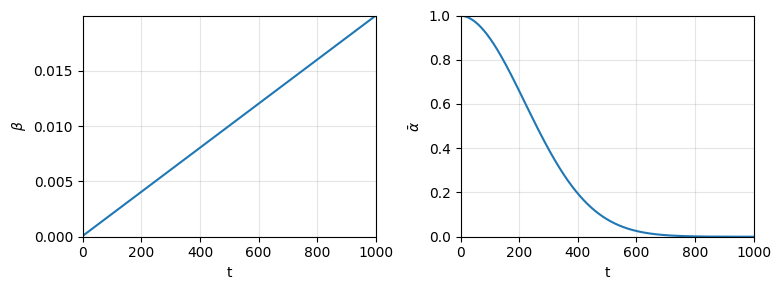

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

ax1.plot(np.arange(len(ddpm.betas)) + 1, ddpm.betas)
ax1.set(xlim=(0, len(ddpm.betas)), ylim=(0, ddpm.betas.max()))
ax1.set(xlabel='t', ylabel='$\\beta$')
ax1.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax1.set_axisbelow(True)

ax2.plot(np.arange(len(ddpm.alphas_bar)) + 1, ddpm.alphas_bar)
ax2.set(xlim=(0, len(ddpm.alphas_bar)), ylim=(0, 1))
ax2.set(xlabel='t', ylabel='$\\bar{\\alpha}$')
ax2.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax2.set_axisbelow(True)

fig.tight_layout()

## Forward process simulation

It is interesting to visualize the forward diffusion process applied to the problem at hand. To that end, the training data are diffused step by step according to $q(\boldsymbol{x}_t | \boldsymbol{x}_{t-1}) = \mathcal{N}(\boldsymbol{x}_t | \sqrt{1-\beta_t} \boldsymbol{x}_{t-1}, \beta_t \boldsymbol{I})$ with the method `diffuse_all_steps`. Intermediate results for certain time steps can then be plotted. This allows us to observe the advancing diffusion process from data to pure noise "in action".

In [ ]:
x_noisy = ddpm.diffuse_all_steps(X_train)

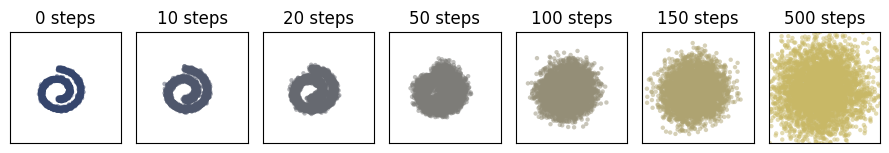

In [ ]:
plot_steps = [0, 10, 20, 50, 100, 150, 500]
colors = plt.cm.cividis(np.linspace(0.2, 0.8, len(plot_steps)))

fig, axes = plt.subplots(nrows=1, ncols=len(plot_steps), figsize=(9, 2))
for time_idx, color, ax in zip(plot_steps, colors, axes.ravel()):
    samples = x_noisy[time_idx].numpy()
    ax.scatter(samples[:,0], samples[:,1], s=10, edgecolors='none', alpha=0.5, color=color)
    ax.set(xlim=(-2.3, 2.7), ylim=(-2.4, 2.6))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title('{} steps'.format(time_idx))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

## Calculate Kurtosis

In [ ]:
import numpy as np
from scipy.stats import kurtosis

In [ ]:
def kurtosis_(data):
  mean_vector = np.mean(data, axis=0)
  covariance_matrix = np.cov(data, rowvar=False)  # Set rowvar to False for variable-wise covariance.

  # Calculate multivariate kurtosis using SciPy's multivariate_normal
  # Calculate multivariate kurtosis using raw moments
  # n = data.shape[0]  # Number of samples
  # excess_kurtosis = 0

  # for i in range(data.shape[1]):  # Iterate over dimensions
  #     m4 = np.sum((data[:, i] - mean_vector[i])**4) / n
  #     m2 = np.sum((data[:, i] - mean_vector[i])**2) / n
  #     excess_kurtosis += m4 / (m2**2)

  # excess_kurtosis -= data.shape[1] * (data.shape[1] + 2)  # Subtract p(p+2) as excess kurtosis

  kurtosis_ = kurtosis(data, fisher=True)
  # total_kurtosis = np.sqrt(np.vdot(kurtosis_, kurtosis_))

  return kurtosis_

## Isotropy Calculation

In [ ]:
def isotropy(data):
  # iso = np.vdot(np.array(data), np.array(data)) / len(data)
  iso = torch.trace((data.T @ data)) / data.size(dim=0)
  return iso

In [ ]:
kurtosis_values = []
kurt_norms = []
iso_values = []

# data_batch = iter(train_loader)
# data_ = next(data_batch)
data_after_one_step = X_train

batch_kurtosis = kurtosis_(data_after_one_step.numpy())
kurt_norm = np.sqrt(np.vdot(batch_kurtosis, batch_kurtosis))
kurt_norms.append(kurt_norm)

batch_isotropy = isotropy(data_after_one_step)
kurtosis_values.append(batch_kurtosis.tolist())
iso_values.append(batch_isotropy)

for index in range(time_steps):
  data_after_one_step = ddpm.diffuse_step(data_after_one_step, index)

  batch_kurtosis = kurtosis_(data_after_one_step.numpy())
  kurtosis_values.append(batch_kurtosis.tolist())

  batch_isotropy = isotropy(data_after_one_step)
  iso_values.append(batch_isotropy)

  kurt_norm = np.sqrt(np.vdot(batch_kurtosis, batch_kurtosis))
  kurt_norms.append(kurt_norm)

In [ ]:
kurts = np.array(kurtosis_values)
kurts.shape
kurts_1 = kurts[:, 0]
kurts_2 = kurts[:, 1]

In [ ]:
def kurt_plot(kurts):
  plt.figure(figsize=(8, 6))

  # Define the window size for the moving average
  window_size = 50

  # Compute the moving average
  smoothed_kurts = np.convolve(kurts, np.ones(window_size)/window_size, mode='same')
  plt.plot(kurts, label='Original kurts');
  plt.plot(smoothed_kurts, label='Smoothed kurts');
  plt.legend()
  plt.xlabel('Time Steps')
  plt.ylabel('Kurtosis Values')
  plt.title('Kurtosis Plot ')
  plt.grid(True);

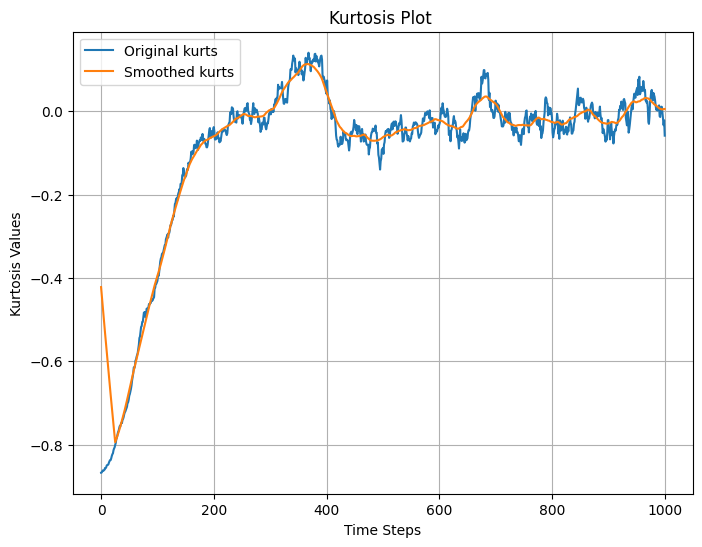

In [ ]:
kurt_plot(kurts_1);

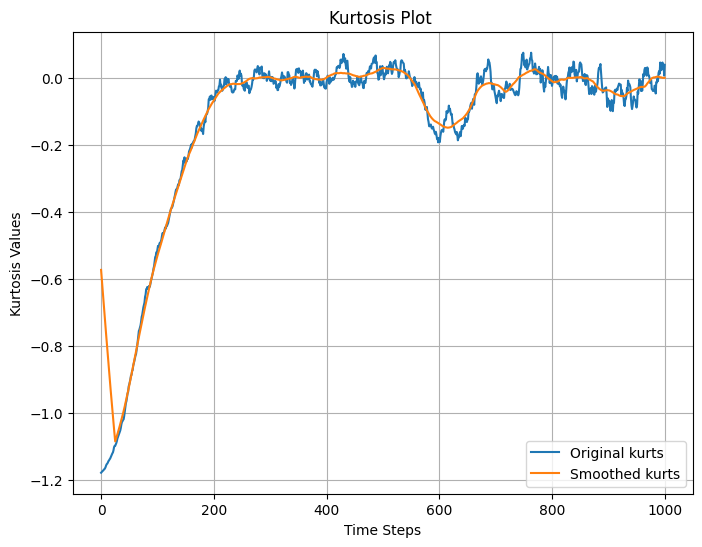

In [ ]:
kurt_plot(kurts_2)

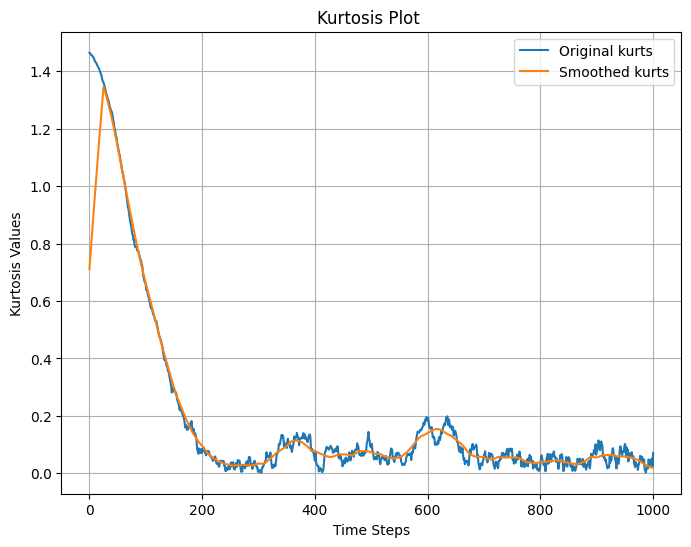

In [ ]:
kurt_plot(kurt_norms);

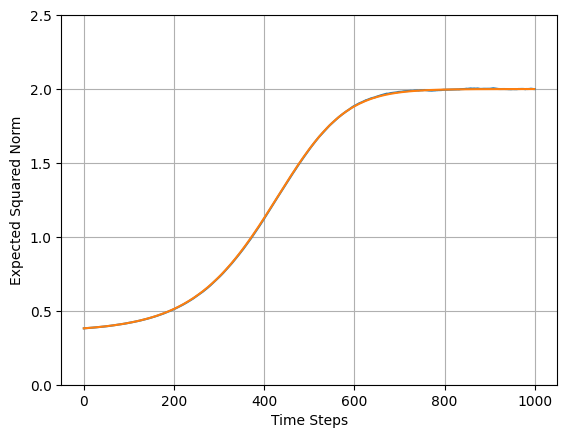

In [ ]:
# plt.legend()
theoretical_norms = 2 +  (isotropy(X_train) - 2)*ddpm.alphas_bar
plt.xlabel('Time Steps')
plt.ylabel('Isotropy Values')
plt.title('Isotropy Variation Plot ')
plt.grid(True)
plt.ylim(0.2, 2.5);
plt.plot(iso_values)
plt.plot(theoretical_norms)
window_size = 50
# plt.plot(np.convolve(iso_values, np.ones(window_size)/window_size, mode='same'));

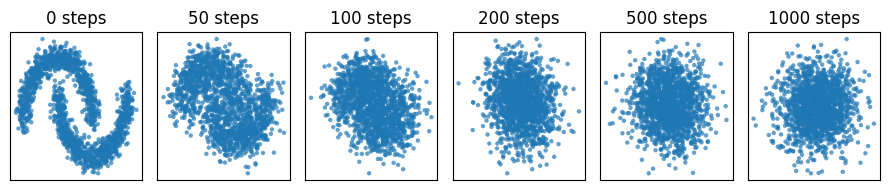

In [ ]:
plot_steps = [0, 50, 100, 200, 500, 1000]

fig, axes = plt.subplots(nrows=1, ncols=len(plot_steps), figsize=(9, 2))
for time_idx, ax in zip(plot_steps, axes.ravel()):
    samples = x_noisy[time_idx].numpy()
    ax.scatter(samples[:,0], samples[:,1], s=10, alpha=0.7, edgecolors='none')
    ax.set_title('{} steps'.format(time_idx))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

It is noted that the simulation of $q(\boldsymbol{x}_t | \boldsymbol{x}_0) = \mathcal{N}(\boldsymbol{x}_t | \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0, (1-\bar{\alpha}_t) \boldsymbol{I})$ at any time step directly is enabled by the method `diffuse`.

## Reverse process training

We are eventually all set for training the model specified above. The loss $L_\text{simple} = \mathbb{E}_{\mathcal{U}(t|1, T), q(\boldsymbol{x}_0), \mathcal{N}(\boldsymbol{\epsilon} | \boldsymbol{0}, \boldsymbol{I})}[\lVert \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\boldsymbol{\theta}(\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1-\bar{\alpha_t}} \boldsymbol{\epsilon}, t) \rVert^2]$ has to be minimized for that purpose. This is accomplished with PyTorch Lightning, a library conveniently performing training, logging and checkpointing.

Note the extreme noise in the train and validation curves below. In addition to the inevitably imperfect and noisy convergence behavior, and the mini-batched evaluation of the training loss, the stochastic loss function here contributes to the overall noise.

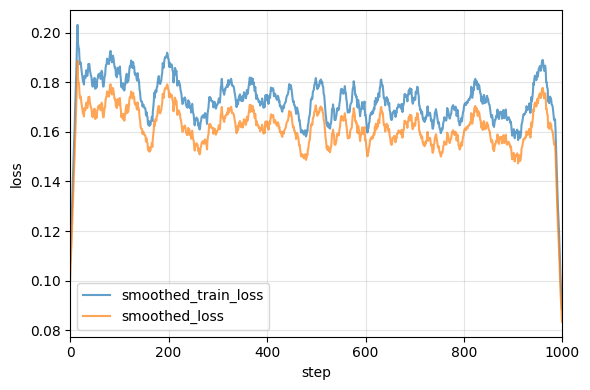

In [ ]:
window_size = 30
# Compute the moving average

fig, ax = plt.subplots(figsize=(6, 4))
# ax.plot(ddpm.train_losses[:], alpha=0.7, label='train')
smoothed_train_loss = np.convolve((ddpm.train_losses)[:], np.ones(window_size)/window_size, mode='same')
ax.plot(torch.tensor(smoothed_train_loss)[:], alpha=0.7, label='smoothed_train_loss')

# ax.plot(torch.tensor(diff_loss)[:], alpha=0.7, label='simple_diff_loss')
smoothed_loss = np.convolve((diff_loss)[:], np.ones(window_size)/window_size, mode='same')
ax.plot(torch.tensor(smoothed_loss)[:], alpha=0.7, label='smoothed_loss')
# ax.plot(ddpm.val_losses, alpha=0.7, label='val')
ax.set(xlabel='step', ylabel='loss')
ax.set_xlim([0, len(ddpm.train_losses)])
ax.legend()
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

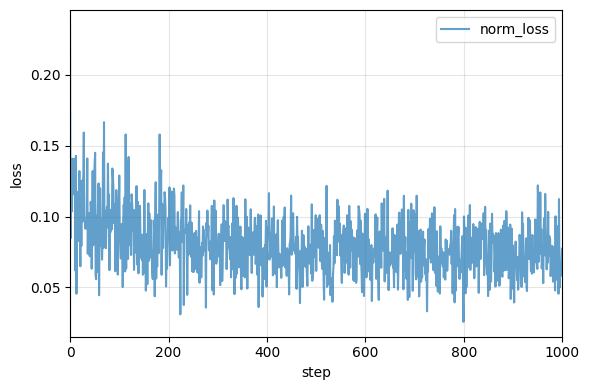

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(torch.tensor(norm_loss_)[:], alpha=0.7, label='norm_loss')
# ax.plot(ddpm.val_losses, alpha=0.7, label='val')
ax.set(xlabel='step', ylabel='loss')
ax.set_xlim([0, len(ddpm.train_losses)])
ax.legend()
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

## Generation

After having trained the model, the denoising process can be used for data generation. The `denoise_all_steps` method allows one to perform $p_\boldsymbol{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t) = \mathcal{N}(\boldsymbol{x}_{t-1} | \boldsymbol{\mu}_\boldsymbol{\theta}(\boldsymbol{x}_t, t), \sigma_t^2 \boldsymbol{I})$ with $\boldsymbol{\mu}_\boldsymbol{\theta}(\boldsymbol{x}_t, t) = \frac{1}{\sqrt{\alpha_t}}(\boldsymbol{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\boldsymbol{\theta}(\boldsymbol{x}_t, t))$ in step-wise fashion. This way, the progressive generation can be visualized for intermediate steps. The evolution from pure noise into the targeted spiral-shaped structure can be observed.

In [ ]:
ddpm.eval()
x_denoise = ddpm.denoise_all_steps(torch.randn(1000, 2))

In [ ]:
plot_steps = [0, 10, 50, 100, 500, 1000]

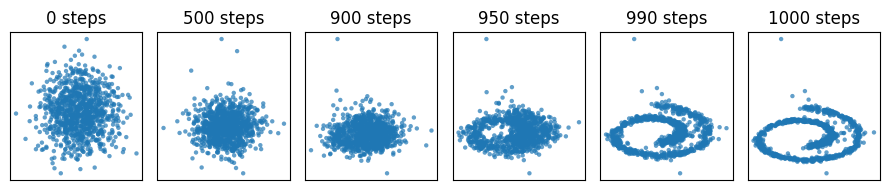

In [ ]:
plot_steps_reverse = [ddpm.num_steps - s for s in reversed(plot_steps)]

fig, axes = plt.subplots(nrows=1, ncols=len(plot_steps_reverse), figsize=(9, 2))
for time_idx, ax in zip(plot_steps_reverse, axes.ravel()):
    samples = x_denoise[time_idx].numpy()
    ax.scatter(samples[:,0], samples[:,1], s=10, alpha=0.7, edgecolors='none')
    ax.set_title('{} steps'.format(time_idx))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

The same process is also implemented by `generate`, without storing intermediate results though. We use this method to generate some final samples.

## Loading a saved model

### load the model params

In [ ]:
from diffusion import *


def load_model(model_name, reg=None, kurt_reg=None):

  from diffusion import (
      ConditionalDenseModel,
      make_beta_schedule
  )

  num_features = [2, 128, 128, 128, 2]

  eps_model_load = ConditionalDenseModel(
      num_features,
      activation='relu',
      embed_dim=50
  )

  betas_load = make_beta_schedule(num_steps=1000, mode='linear', beta_range=(1e-04, 0.02))
  # betas = make_beta_schedule(num_steps=1000, mode='quadratic', beta_range=(1e-04, 0.02))
  # betas = make_beta_schedule(num_steps=time_steps, mode='cosine', cosine_s=0.008)
  # betas = make_beta_schedule(num_steps=1000, mode='sigmoid', sigmoid_range=(-5, 5))
  if 'original' in model_name:
    from diffusion.ddpm import DDPM as ddpm
    print('original')
    ddpm_load = ddpm(
      eps_model=eps_model_load,
      betas=betas_load,
      criterion='mse',
      lr=1e-03
      )
  elif 'norms' in model_name:
    from diffusion.ddpm_norms import DDPM as ddpm
    print('norms')
    ddpm_load = ddpm(
      eps_model=eps_model_load,
      betas=betas_load,
      criterion='mse',
      lr=1e-03,
      reg=reg
      )
  else:
    from diffusion.ddpm_kurtosis import DDPM as ddpm
    print('kurtosis')
    ddpm_load = ddpm(
      eps_model=eps_model_load,
      betas=betas_load,
      criterion='mse',
      lr=1e-03,
      reg=reg,
      kurt_reg=kurt_reg
      )



  model_name = model_name
  model_load_path = '/content/drive/MyDrive/Diffusion_Models/diffusion-demo-dilum/saved_models/' + model_name
  sys.path.append(model_load_path)

  # # # load saved path to your new model
  ddpm_load.load_state_dict(torch.load(model_load_path))

  return ddpm_load

In [ ]:
from google.colab import files
import os

def plot_and_save(x_gen, file_name):
  # Create figure and axes
  fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

  # Plot the scatter points
  ax.scatter(x_gen[:,0], x_gen[:,1], label='Generated', s=8, alpha=0.7, edgecolors='none')
  ax.scatter(X_test[:,0], X_test[:,1], label='Original', s=8, alpha=0.7, edgecolors='none')

  # Set limits and aspect ratio
  ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
  ax.set_aspect('equal', adjustable='box')

  # Hide borders, ticks, and labels
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', which='both', length=0)
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  # No grid
  ax.grid(False)

  # Set legend
  ax.legend(fontsize=12)

  # Set axis below
  ax.set_axisbelow(True)

  # Tight layout
  fig.tight_layout()

  # Save the plot to Google Drive folder
  save_folder = '/content/drive/MyDrive/Diffusion_Models/diffusion-demo-dilum/Images/swiss_roll'
  save_path = os.path.join(save_folder, file_name)
  plt.savefig(save_path)

  # Provide feedback
  print(f"Plot saved to: {save_path}")

In [ ]:
random_state = 40
input = 'swiss_roll'

if input == 'swiss_roll':
  X_test = create_swiss_roll_samples(num_samples=10000)
elif input == 'moons':
  X_test, labels = create_moons_samples(num_samples=10000)
elif input == 's_curve':
  X_test = create_s_curve(num_samples=10000)
else:
  X_test, _ = create_8_gaussians(num_samples=10000)

# model = load_model(model_name='make_moons/norms/norms_reg_0.2_model_1')
regs_list = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3]

prdc = []
isotrops = []

for j in range(0, len(regs_list)):
  iso = []
  for k in range(1, 2):
    if j == 0:
      if input == 'swiss_roll':
        model_name = f'{input}/original_{k}'
      else:
        model_name = f'{input}/original/original_{k}'

      model = load_model(model_name)
      model.eval()
      save_name = 'original.png'
    else:
      model_name = f'{input}/norms/norms_reg_{regs_list[j]}_model_{k}'

      model = load_model(model_name)
      model.eval()
      save_name = f'reg_{regs_list[j]}_{k}.png'

    x_gen, isotropy = model.generate(sample_shape=(2,), num_samples=10000)

    plot_and_save(x_gen, save_name)
  #   iso.append(isotropy)
  #   prdc_ = compute_prdc(real_features=X_test, fake_features=x_gen, nearest_k=5);
  #   prdc_ = torch.Tensor(list(prdc_.values()))
  #   prdc.append(prdc_)

  # isotrops.append(iso)
  # prdc_metrics = torch.stack(prdc, dim=0)
  # mean_metrics = torch.mean(prdc_metrics, dim=0)
  # std_metrics = torch.std(prdc_metrics, dim=0)

  # num_metrics = 4
  # metric_names = ['Precision', 'Recall', 'Density', 'Coverage']
  # print(f"\n model with reg: {regs_list[j]} \n")
  # for i in range(0, num_metrics):
  #   print(f"{metric_names[i]} : {mean_metrics[i]:.4f} +/- {std_metrics[i]:.4f}")

In [ ]:
random_state = 40

input = 'swiss_roll'

if input == 'swiss_roll':
  X_test = create_swiss_roll_samples(num_samples=10000, random_state=random_state)
else:
  X_test, _ = create_8_gaussians(num_samples=10000, random_state=random_state)

# model = load_model(model_name=f'{input}/norms/norms_reg_0.3_model_1')
model = load_model(model_name=f'{input}/original_1')
# swiss_roll/original_1
model.eval()
x_gen, isotropy_ = model.generate(sample_shape=(2,), num_samples=10000)

prdc_ = compute_prdc(real_features=X_test, fake_features=x_gen, nearest_k=5)
list(prdc_.values())

original
Num real: 10000 Num fake: 10000


[0.9106, 0.9992, 0.85192, 0.9228]

In [ ]:
alphas_bar = ddpm.alphas_bar

In [ ]:
initial_iso = isotropy(torch.tensor(X_test))

<ipython-input-143-09a0e55631ea>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax.plot(torch.tensor(theoretical_norms)[:], alpha=0.7, color='red', linewidth=2.0, label='theoretical')


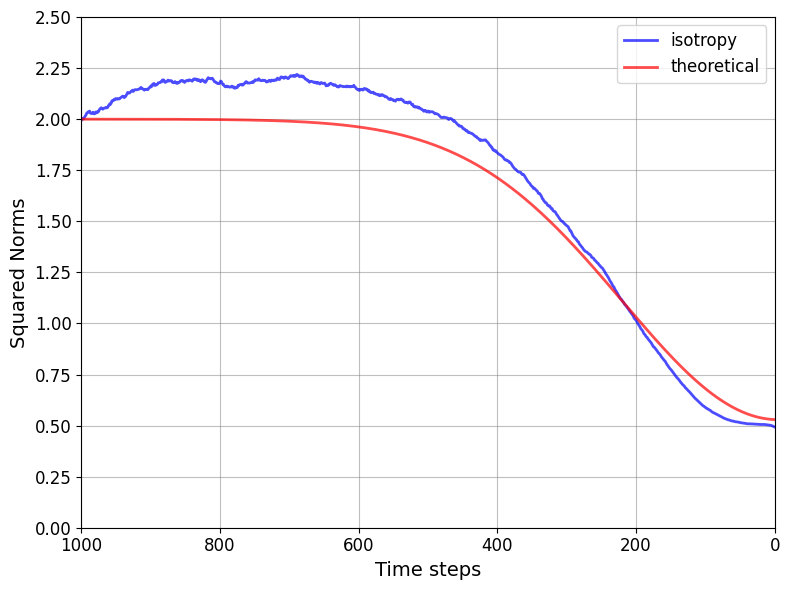

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(torch.tensor(isotropy_)[:], alpha=0.7, color='blue', linewidth=2.0, label='isotropy')
theoretical_norms = 2 +  (initial_iso - 2)*torch.flip(alphas_bar, [0])
ax.plot(torch.tensor(theoretical_norms)[:], alpha=0.7, color='red', linewidth=2.0, label='theoretical')
ax.plot()
ax.set_axisbelow(True)
fig.tight_layout()

# Set the labels for the x-axis and y-axis with appropriate font sizes
plt.xlabel('Time steps', fontsize=14)  # X-axis label font size set to 14 points
plt.ylabel('Squared Norms', fontsize=14)  # Y-axis label font size set to 14 points

# Set y-axis limit between 0 and 2.5
plt.ylim(0, 2.5)

# Set x-axis limit between 0 and 1000
plt.xlim(0, 1000)

# Set tick label font size for both x-axis and y-axis
plt.xticks(np.arange(0, 1000.1, 200), fontsize=12)  # Set x-axis grid line spacing
plt.yticks(np.arange(0, 2.51, 0.25), fontsize=12)

# Flip the x-axis tick labels
plt.gca().set_xticklabels(reversed(plt.gca().get_xticklabels()))

plt.grid(True, linewidth=0.8, color='gray', alpha=0.5)
plt.legend(fontsize=12)  # Set legend font size to 12 points
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('cvpr_style_plot.png', dpi=300)  # Save the plot as an image file
plt.show()  # Display the plot

original
[0.8906, 0.9988, 0.81962, 0.8657]
[0.9051, 0.9988, 0.84628, 0.9189]


0.01
[0.9137, 0.9982, 0.8544, 0.8853]
[0.9549, 0.9984, 0.9147600000000001, 0.9098]

0.05
[0.9713, 0.9921, 0.94904, 0.9032]
[0.9722, 0.9912, 0.9672800000000001, 0.9379]

0.10
[0.9822, 0.9848, 0.9824, 0.9176]
[0.9839, 0.9879, 0.98944, 0.9117]


0.20
[0.9914, 0.9843, 1.0034800000000001, 0.9034]
[0.9874, 0.9817, 0.9970800000000001, 0.8482]

0.30
[0.9866, 0.9794, 0.9996200000000001, 0.894]
[0.9896, 0.9592, 1.01466, 0.8337]

samples = 5000
norms_reg_0.2
[0.9896, 0.9829, 0.991761, 0.8553]
[0.9887, 0.9833, 0.9997, 0.8583]

norms_reg_0.2_0
[0.9915, 0.9813, 1.00076, 0.9069]
[0.9906, 0.9788, 1.01498, 0.9106]

original_0
[0.9686, 0.9968, 0.94612, 0.9316]
[0.9666, 0.9978, 0.95196, 0.9281]

original_1
[0.9485, 0.9962, 0.89172, 0.8616]
[0.9487, 0.9953, 0.89556, 0.8612]

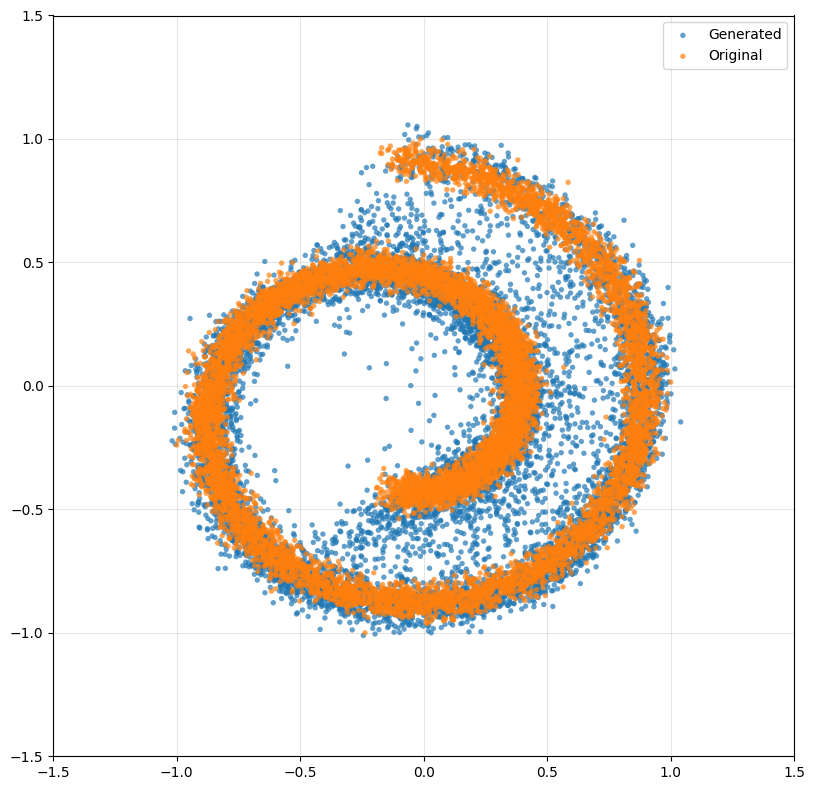

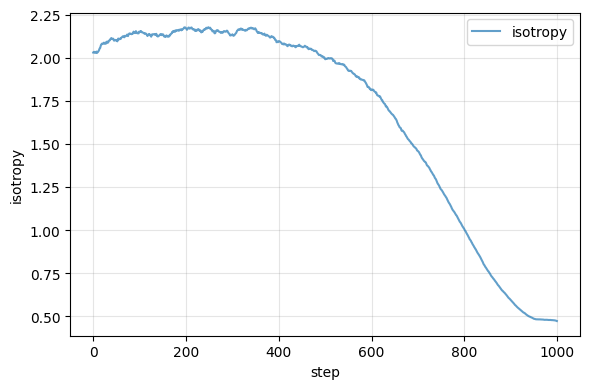

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(torch.tensor(isotropy)[:], alpha=0.7, label='isotropy')
# ax.plot(ddpm.val_losses, alpha=0.7, label='val')
ax.set(xlabel='step', ylabel='isotropy')
# ax.set_xlim([0, len(ddpm.train_losses)])
ax.legend()
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

In [ ]:
def evaluation(model_):
  # Create test data set
  random_state = 42
  X_test = create_swiss_roll_samples(num_samples=10000, random_state=random_state)

  # Evaluate each model 3 times
  num_evaluations = 3

  nearest_k = 5

  metrics_model_1 = []
  metrics_model_2 = []
  metrics_model_3 = []

  for _ in range(num_evaluations):

    # load the models
    model_1 = load_model(model_name=model_)
    model_2 = load_model(model_name=model_ + '_1')
    model_3 = load_model(model_name=model_ + '_2')

    x_gen_1, isotropy_1 = model_1.generate(sample_shape=(2,), num_samples=10000)
    prdc_1 = compute_prdc(real_features=X_test, fake_features=x_gen_1, nearest_k=nearest_k)
    prdc_1 = list(prdc_1.values())
    metric_names = list(prdc_1)
    metrics_model_1.append(prdc_1)
    print('model_1')

    x_gen_2, isotropy_2 = model_2.generate(sample_shape=(2,), num_samples=10000)
    prdc_2 = compute_prdc(real_features=X_test, fake_features=x_gen_2, nearest_k=nearest_k)
    prdc_2 = list(prdc_2.values())
    metrics_model_2.append(prdc_2)
    print('model_2')

    x_gen_3, isotropy_3 = model_3.generate(sample_shape=(2,), num_samples=10000)
    prdc_3 = compute_prdc(real_features=X_test, fake_features=x_gen_3, nearest_k=nearest_k)
    prdc_3 = list(prdc_3.values())
    metrics_model_3.append(prdc_3)
    print('model_3')

  mean_metrics_model_1 = torch.tensor(metrics_model_1).mean(dim=0)
  mean_metrics_model_2 = torch.tensor(metrics_model_2).mean(dim=0)
  mean_metrics_model_3 = torch.tensor(metrics_model_3).mean(dim=0)

  means = [mean_metrics_model_1, mean_metrics_model_2, mean_metrics_model_3]

  std_metrics_model_1 = torch.tensor(metrics_model_1).std(dim=0)
  std_metrics_model_2 = torch.tensor(metrics_model_2).std(dim=0)
  std_metrics_model_3 = torch.tensor(metrics_model_3).std(dim=0)

  stds = [std_metrics_model_1, std_metrics_model_2, std_metrics_model_3]

  return means, stds

In [ ]:
def calculate_average_metrics(means, stds):
  final_means = torch.stack(means).mean(dim=0)
  final_stds = torch.stack(stds).std(dim=0)

  metric_names = ['Precision', 'Recall', 'Density', 'Coverage']
  num_metrics = 4
  for i in range(0, num_metrics):
      print(f"{metric_names[i]}: mean = {final_means[i]:.4f}")
  print('\n')

  return final_means, final_stds

In [ ]:
def print_results(model_):
  means, stds = evaluation(model_)

  # Number of trained models
  num_models = 3
  # Precision, Recall, Density and Coverage
  num_metrics = 4
  metric_names = ['Precision', 'Recall', 'Density', 'Coverage']
  for k in range(0, num_models):
    mean_of_model = means[k]
    std_of_model = stds[k]
    for i in range(0, num_metrics):
      print(f"Model {k+1} , {metric_names[i]}: mean = {mean_of_model[i]:.4f}")
    print('\n')

  return means, stds

In [ ]:
means, stds = print_results(model_='lamb_1_torch')

Num real: 10000 Num fake: 10000
model_1
Num real: 10000 Num fake: 10000
model_2
Num real: 10000 Num fake: 10000
model_3
Num real: 10000 Num fake: 10000
model_1
Num real: 10000 Num fake: 10000
model_2
Num real: 10000 Num fake: 10000
model_3
Num real: 10000 Num fake: 10000
model_1
Num real: 10000 Num fake: 10000
model_2
Num real: 10000 Num fake: 10000
model_3
Model 1 , Precision: mean = 0.9047
Model 1 , Recall: mean = 0.9987
Model 1 , Density: mean = 0.8403
Model 1 , Coverage: mean = 0.9227


Model 2 , Precision: mean = 0.9122
Model 2 , Recall: mean = 0.9986
Model 2 , Density: mean = 0.8652
Model 2 , Coverage: mean = 0.9297


Model 3 , Precision: mean = 0.9327
Model 3 , Recall: mean = 0.9987
Model 3 , Density: mean = 0.8748
Model 3 , Coverage: mean = 0.9131




For norm_reg = 0.1, as kurts are added in decreasing fashion, metrics improve

[0.925, 0.9603, 0.9002800000000001, 0.7813] (kurt = 0.1)
[0.958, 0.965, 0.92652, 0.7971] (kurt = 0.01)
[0.9639, 0.9682, 0.95872, 0.8214] (kurt =0.005)

For norm_reg = 0.05

[0.9286, 0.9958, 0.87068, 0.8529] (no kurt)
[0.5434, 0.9987, 0.40784000000000004, 0.6497] (kurt = 0.1)
[0.9568, 0.99, 0.9254600000000001, 0.8276] (kurt = 0.01)
[0.9316, 0.9962, 0.8777200000000001, 0.8324] (kurt = 0.005)

For norm_reg = 0.2
[0.9538, 0.9912, 0.9516, 0.8868] (no kurt)
[0.7313, 0.9751, 0.60602, 0.5827] (kurt = 0.1)
[0.9494, 0.9782, 0.94216, 0.8298] (kurt = 0.01)

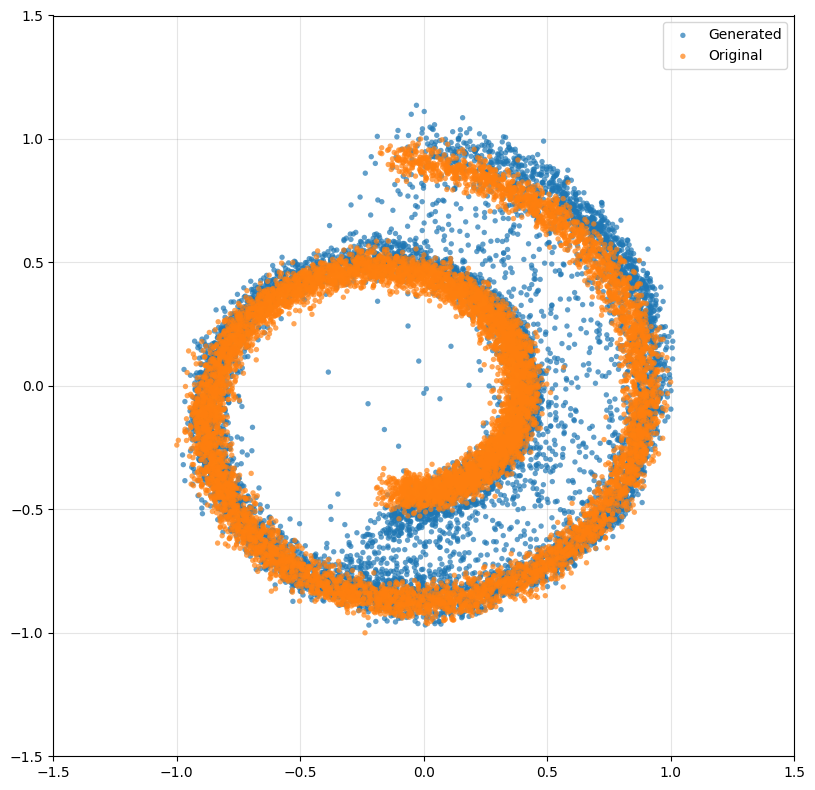

Well, it seems to work!